# Лекция 5: MapReduce

- [статья на Habr-е](https://habr.com/ru/companies/skillfactory/articles/882328/)
- [статья №2](https://neurohive.io/ru/tutorial/mapreduce/)
- тут рассмотрим, что означает обработка данных MapReduce-ом

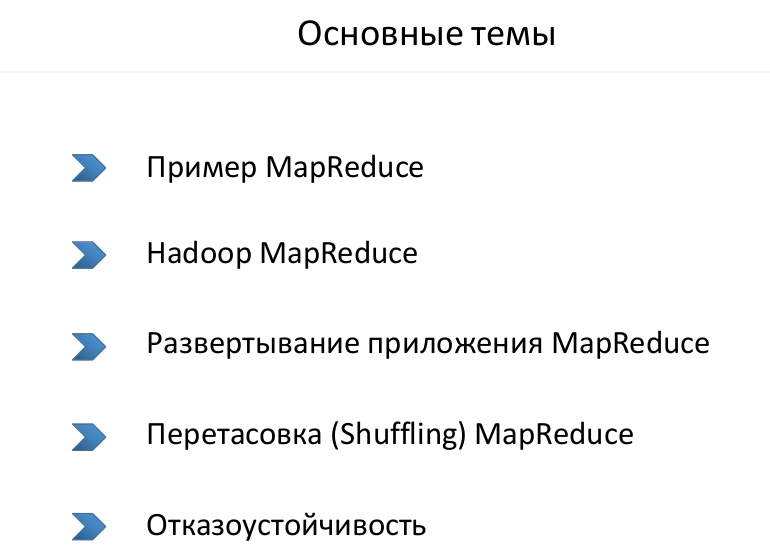

### Пример на MapReduce

Условие: Пусть у нас есть файл, который разбит по страницам. И на каждой странице нужно посчитать среднее значение букв.

![image copy.png](<attachment:image copy.png>)
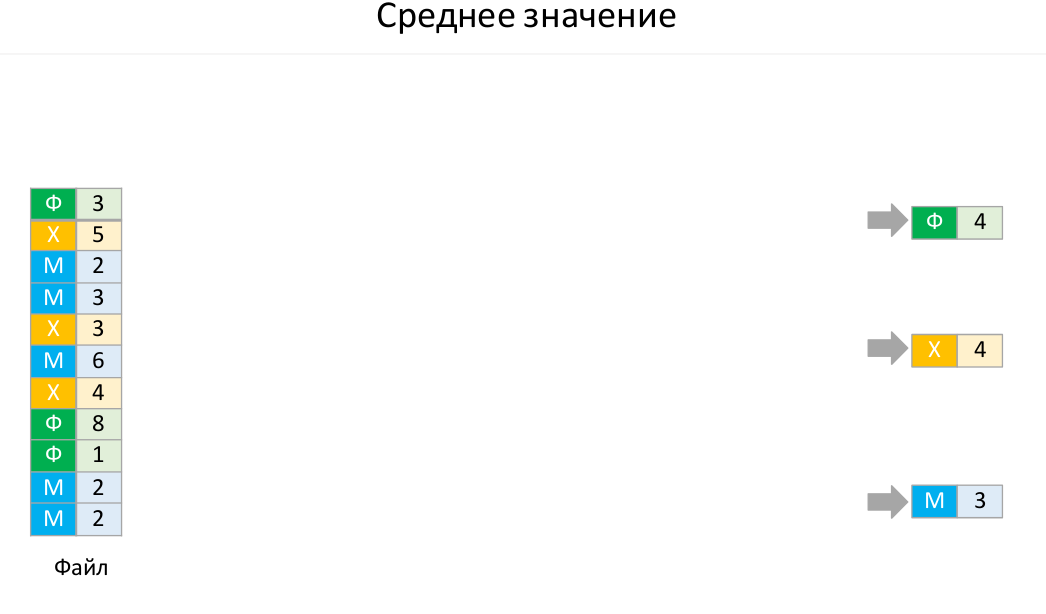

Ну человек, который не сталкивался с парадигмой решения такого рода задач, говорит так:
1) Мы заведем буфер, где будем харнить число вхождения букв на странице
2) И указателем бем проходиться по документу и инкрементировать соответствующие значения в буфере
Задача так решиться, но что если файл очень большой? Тогда буфера уже начнет не хватать...

![image copy 2.png](<attachment:image copy 2.png>)

1) Разобьем файл на рандомные части (HADOOP же распределенная система...)
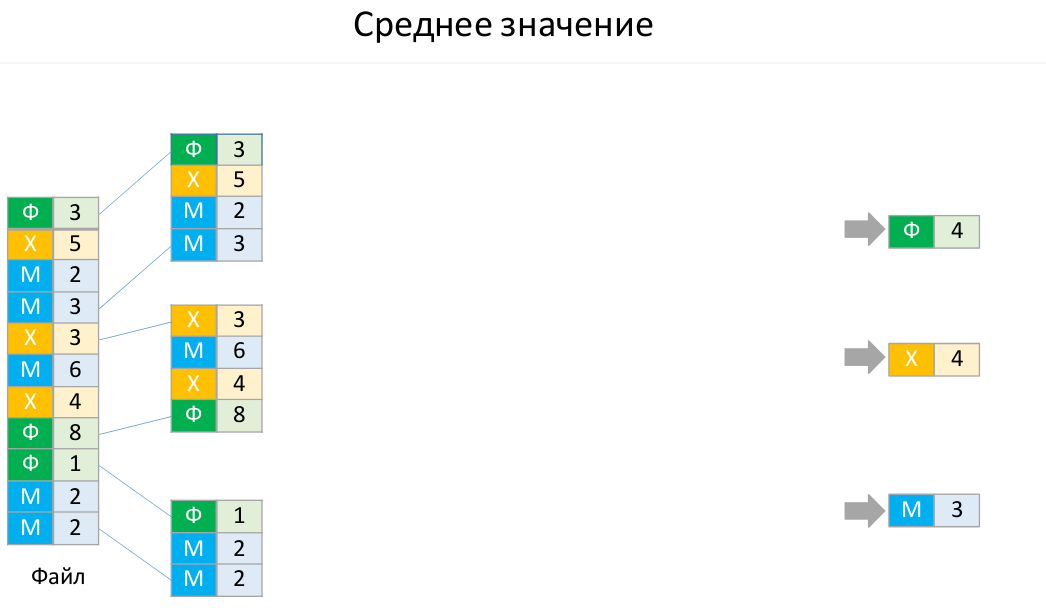

![image copy 3.png](<attachment:image copy 3.png>)

2) Далее введем дополнительную колонку и заполним ее единицами, пока что не понятно зачем, но потом поймем...
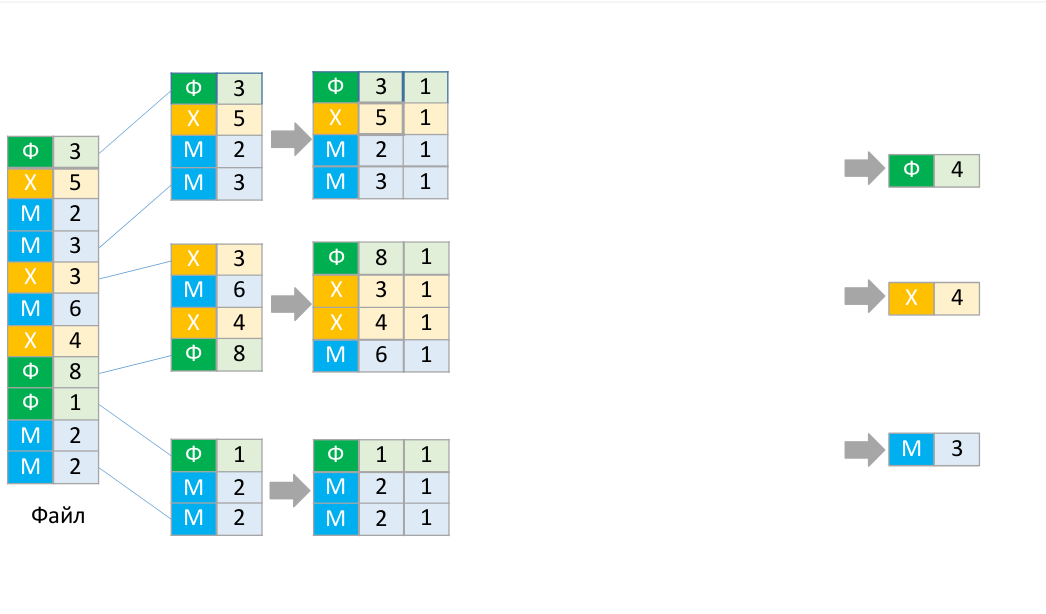

![image copy 4.png](<attachment:image copy 4.png>)

3) Далее возьмем и какатенируем буквы, которые одинаковые в файле
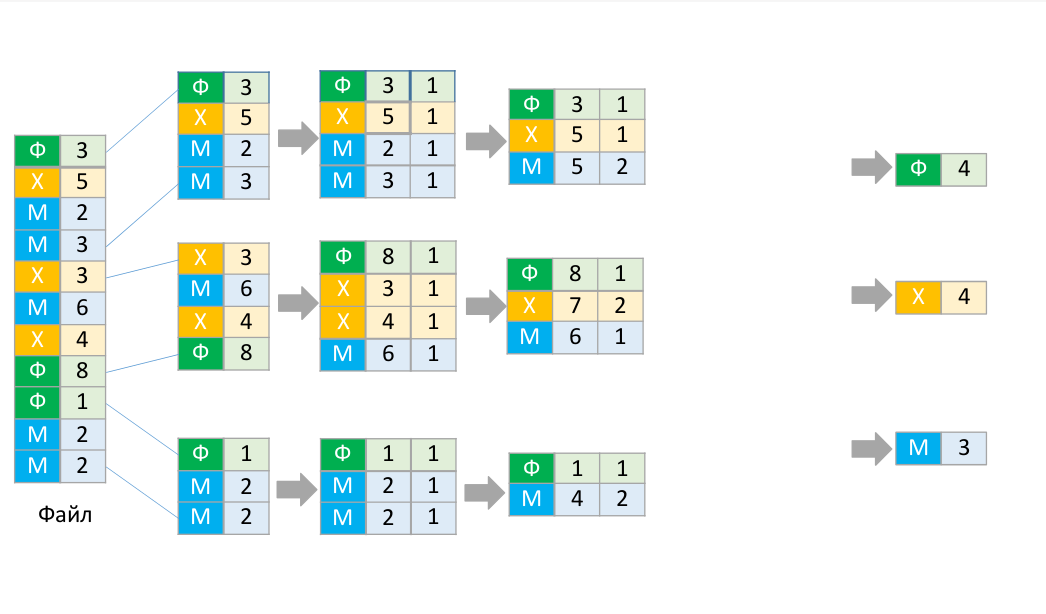

![image copy 5.png](<attachment:image copy 5.png>)

4) Дальше мы просто берем и перетасовываем буквы таким образом, чтобы одинаковые буквы попали в одни блоки и никакие значения не меняем...
5) А дальше мы просто складываем значения первого столбца и делим на значение второго столбца
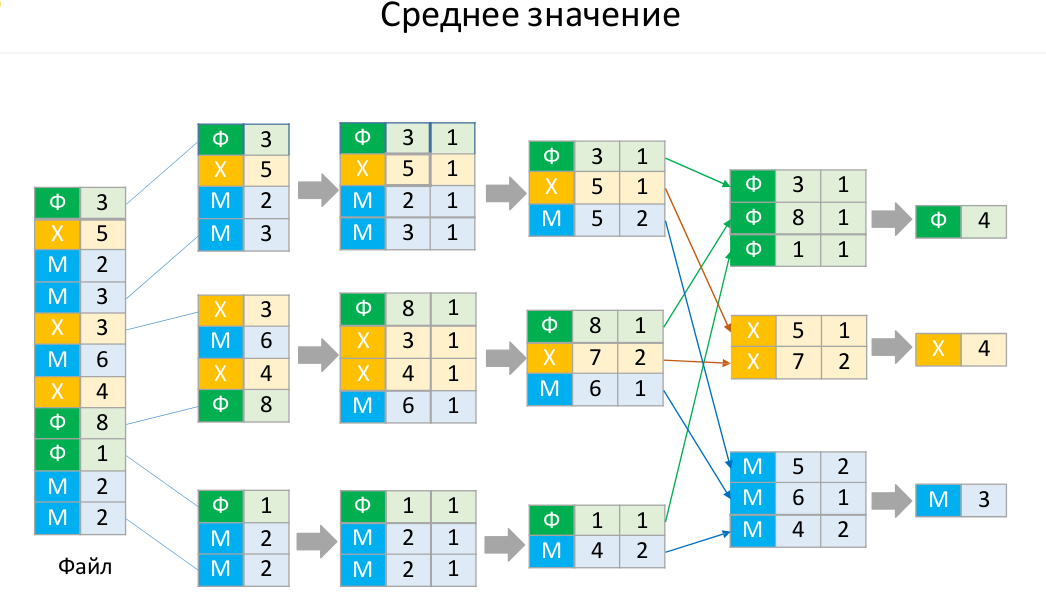

### Почему такой подход имеет место быть?
- он же заморочен...

Он будет намного выгоднее на больших данных из-за:
- мы сделали распараллеливание из-за чего мы можем этот блок поместить в отдельный DataNode размером 64/128/256
- процесс деления файла легкий...
- добавление колонок с единицой тоже не вычислительно сложна, а тем более для маленьких блоков
- операции суммирования и инкриментации тоже легкие
- единственная сложная операция это `GROUP BY`, но она тоже не самая тяжелоя в БД
- `SHUFLING` - перемешивание по блокам. Как раз 4 пункт в нашем примере. Нам нужно перекинуть эти блоки на новые DataNode-ы или просто затерять на предыдущих  DataNode-ах


![image copy 6.png](<attachment:image copy 6.png>)
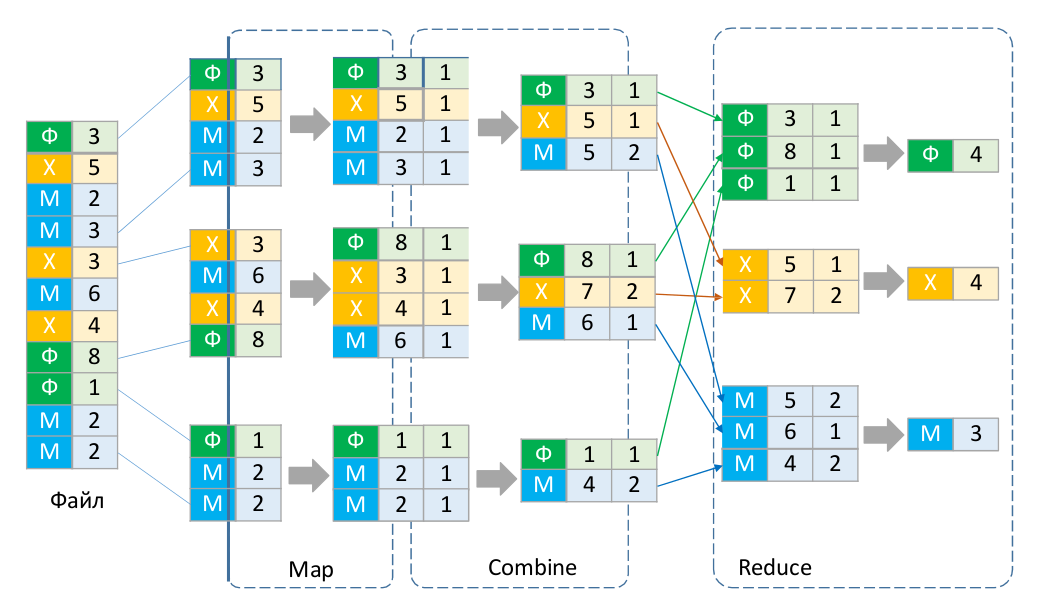

- 1 шаг: **MAP**  - разделение на блоки
- 2 шаг: **Combine** - обозначает некоторые преобразования
- 3 шаг: **Reduce** - сопровождает перемешиванием/Shufling и количественные вычисления...

### Реализация MapReduce в Hadoop

![image copy 7.png](<attachment:image copy 7.png>)
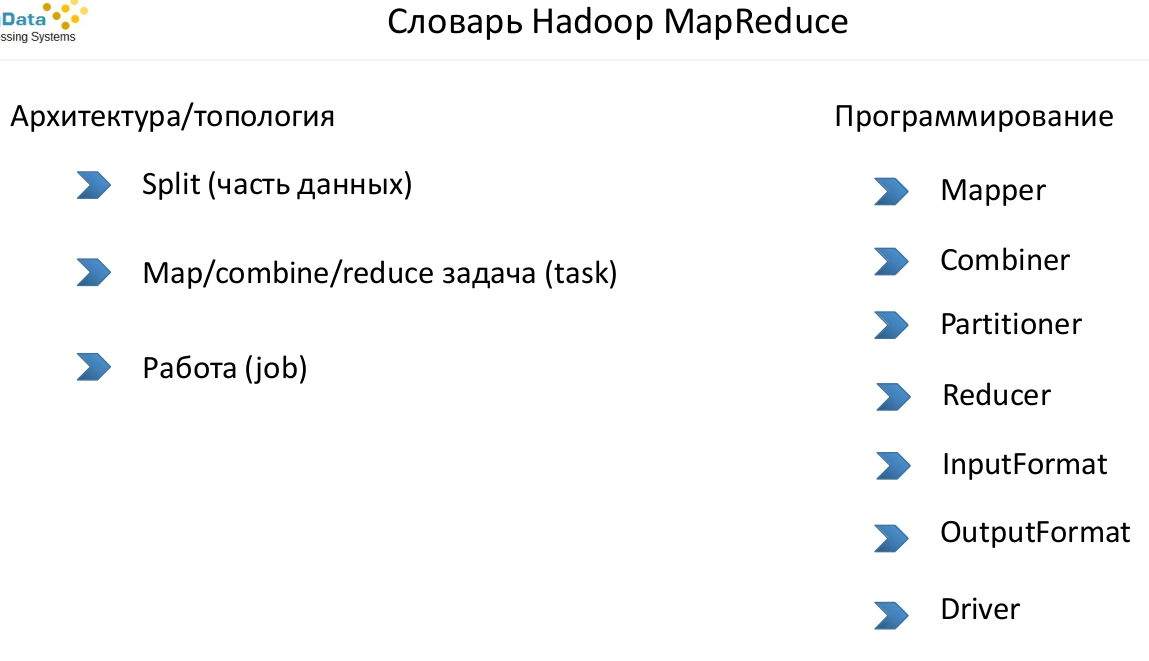

![image copy 8.png](<attachment:image copy 8.png>)

Split-ы могут обрабатываться на разных узлах или могут обрабатываться на одном узле (это не пренципиально), но задача REDUECE должна выполняться на других узлах, чтобы не было конфликтов и сохранялась идея распараллеливания

- Если же один узел не может обработать несколько "блоков", то он дает сообщение NodeManager-у, который дает сообщение MapReduce-у
- И иногда будет выделяться задача под ноду, где есть хоть сколько-то ресурсов, ведь важно, чтобы задача выполнилась хоть как-то...
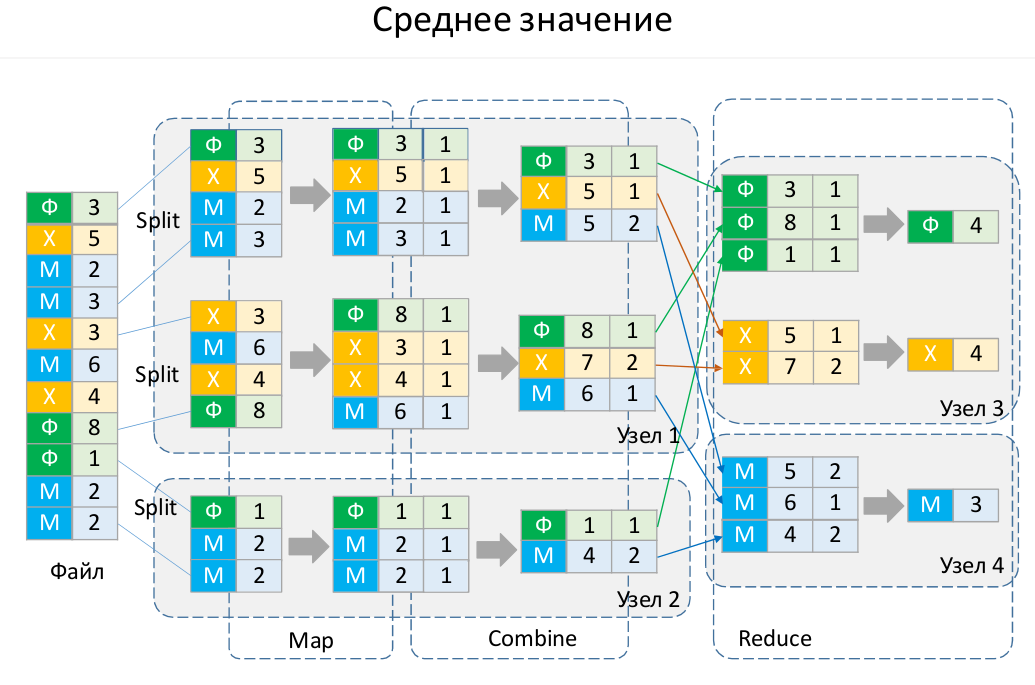

### Особенности реализации MapReduce в Hadoop

- MapReduce работа (job) состоит из стадии map и reduce 

**(Стадия map + Стадия reduce = job)**

- Стадия map – преобразование исходных данных
- Стадия reduce – агрегация данных стадии map
- MapReduce работа (job) разбивает исходные данные на независимые логические части – splits. 
- Размер split <=> размера блока HDFS. Если больше, то теряется data locality `Размер split-а должен быть соизмерим с блоком в HDFS`
- Одному split соответствует одна map-задача
- Задачи запускаются и выполняются параллельно (в идеальном случае)

![image copy 10.png](<attachment:image copy 10.png>)

во втором пункте мы говорим, что должно выполниться 5% map-задач, а зачем если мы поделили на одинаковые блоки, то и задачи же должны выполниться вроде одновременно...
Но мы никогда не увидем, что 2 вычислителя выполнят задачу одновременно, тем более если несколько вычислений... Следовательно map и combine-у нужно время для выполнения хоть каких-то задач, а так REDUCE запускался бы на частично выполненной работе map-ом и combine-ом
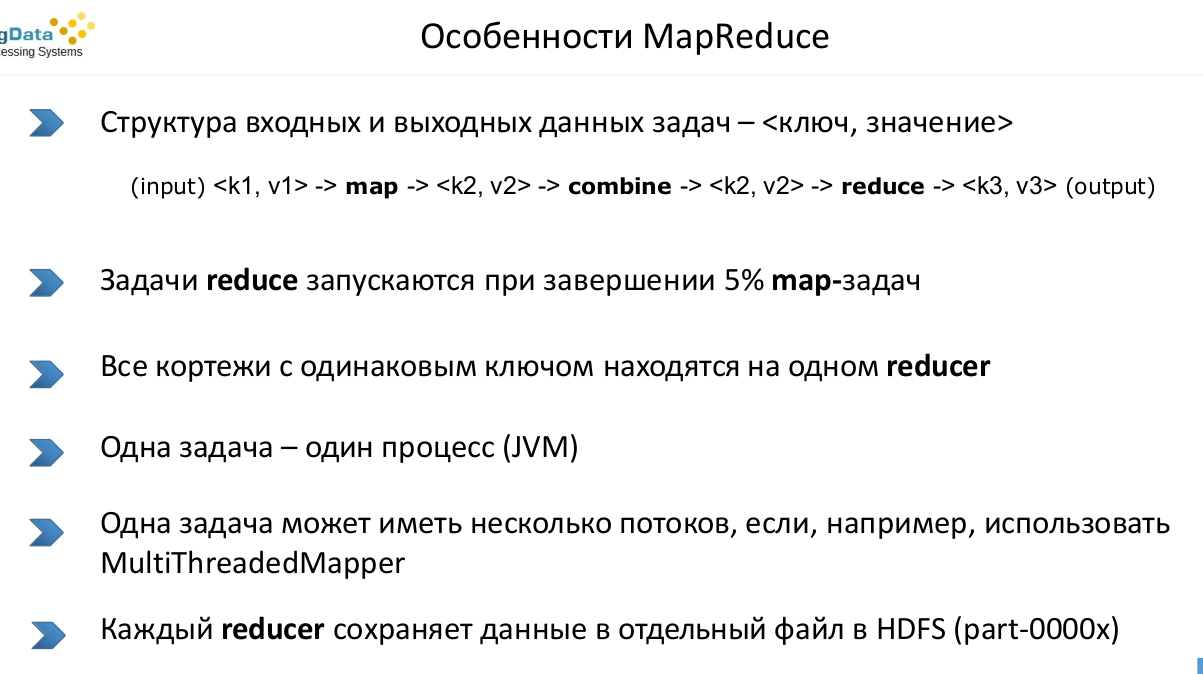

### Архитектура MapReduce

![image copy 11.png](<attachment:image copy 11.png>)

- данные приходят с HDFS
- у нас есть NodeManager-ы 1 и 2 они отвечают за запуск задач на контейнере, он может запускать несколько задач map в одном контейнере
- также есть NodeManager-ы 3 и 4, которые отвечают за запуск задач Reduce и они же получают результат после этой операции
- данные также сохраняются на HDFS
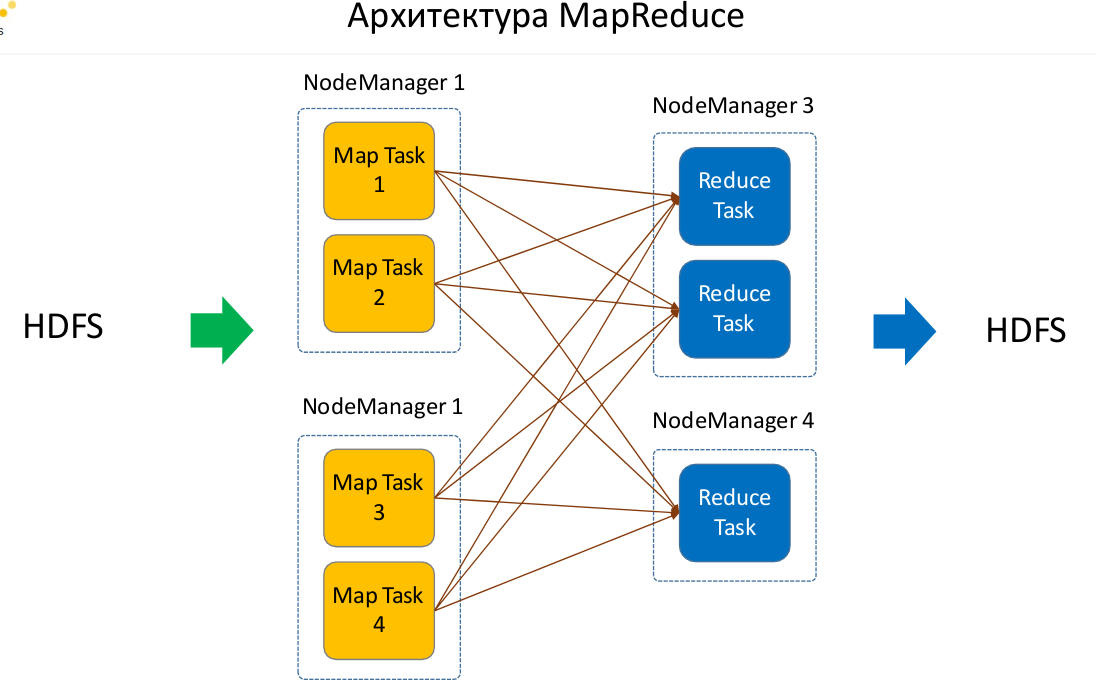

### Архитектура MapCombineReduce

![image copy 12.png](<attachment:image copy 12.png>)

- `combiner-ы` выполняются в тех же узлах и контейнерах, что и `Map задачи`
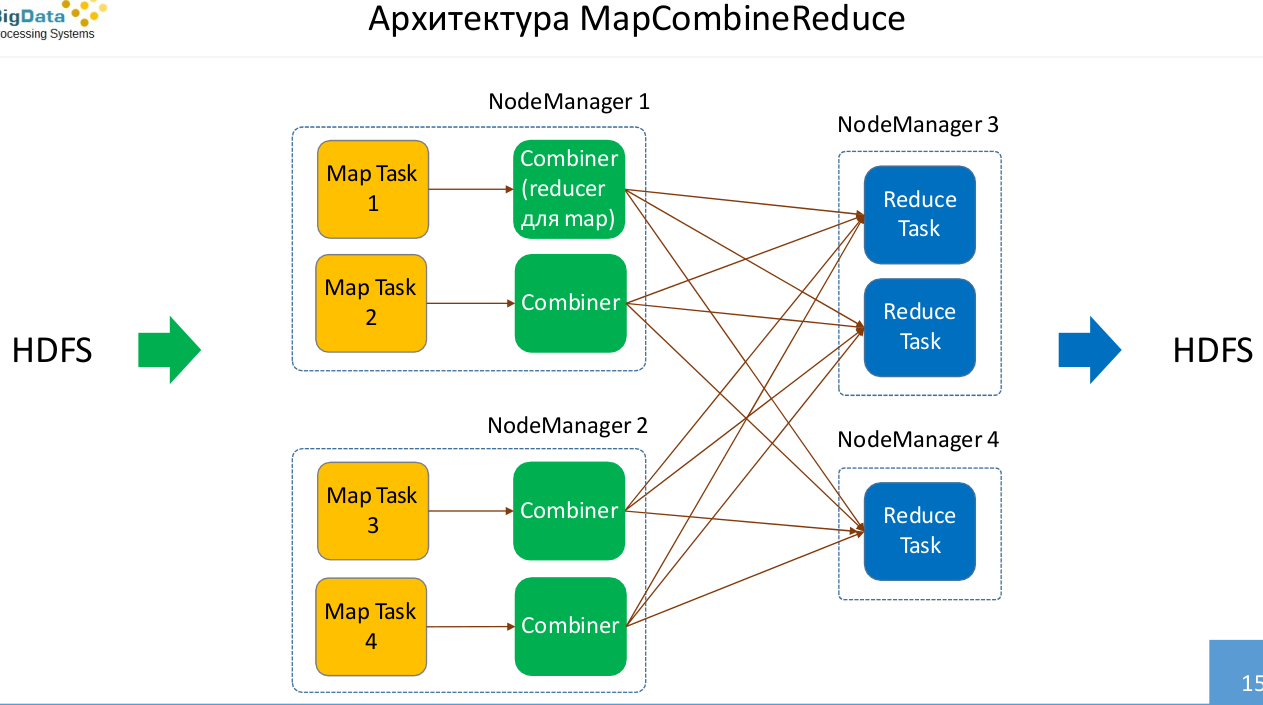

![image copy 13.png](<attachment:image copy 13.png>)

- входные данные для Map задач храняться на DataNode-ах в тех блоках, как мы их поделили.
- но не факт, что блоки могут быть равны split-ам. Мы можем болки пилить, если они слишком велики.
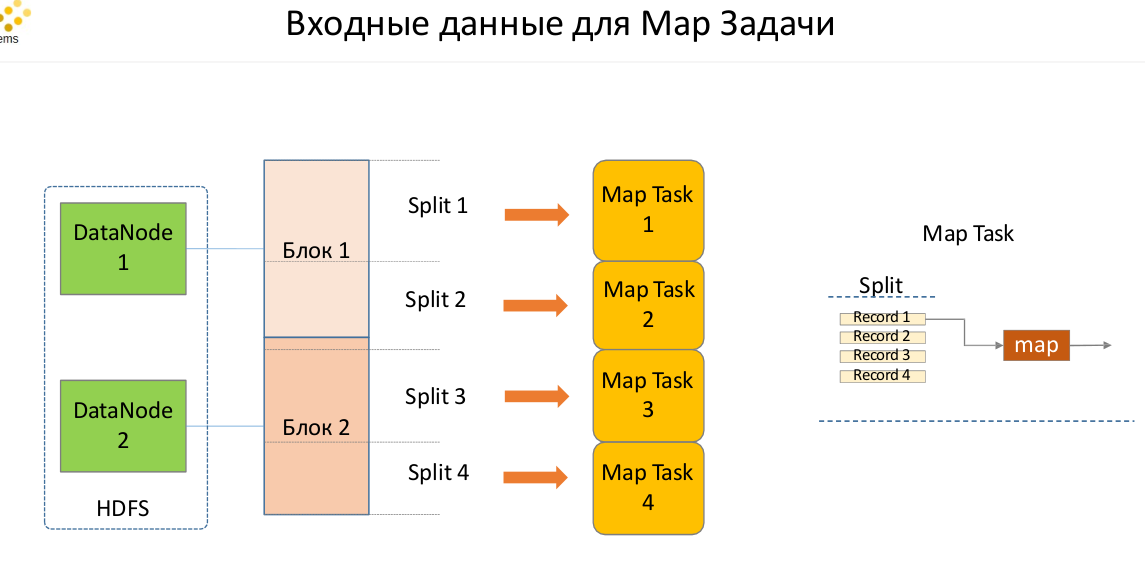

---

### Лекция 5 началось здесь, до этого все было разобрано на 4-й лекции

--- 

![image copy 14.png](<attachment:image copy 14.png>)
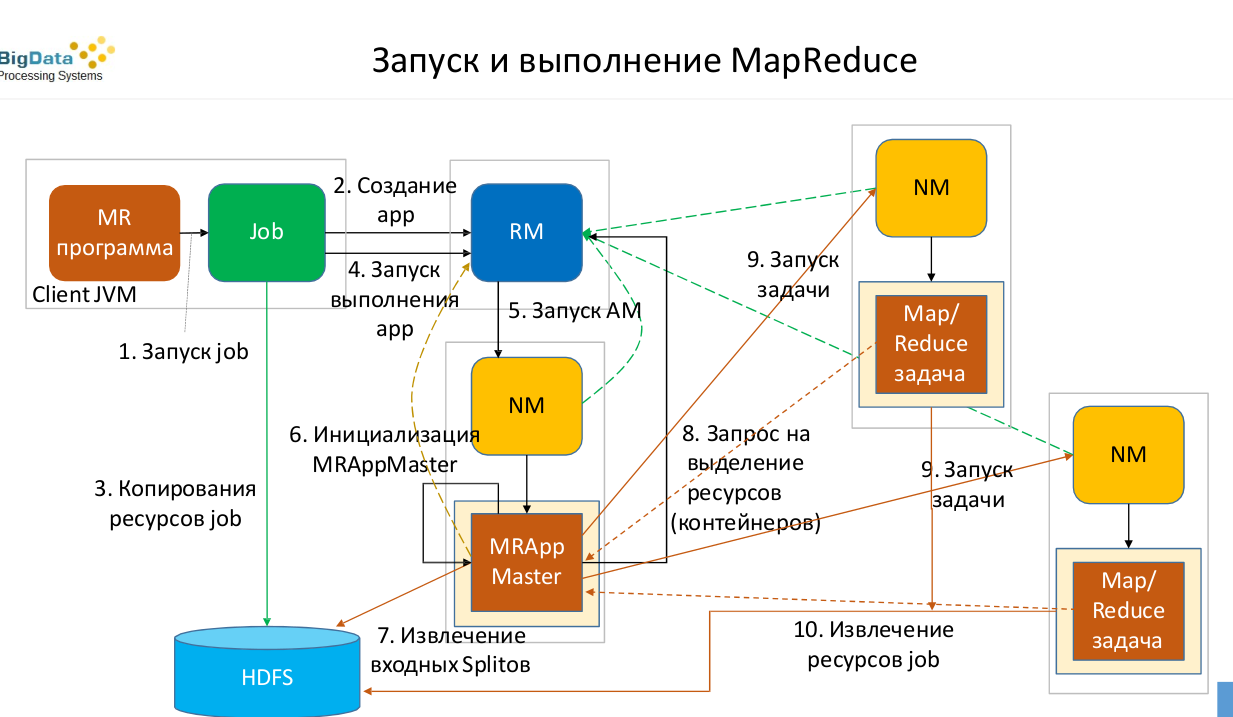

`MapReduce` надо рассматривать не как самостоятельная единица, а как программа, которая работает в сочетании с `HDFS` и `YARN`.

На рисунке сверху можно увидеть:
`RM` - ResuarceManager
`NM` - NodeManager
`HDFS` - HDFS

0) Вообще MapReduce это программа написанная в ООП стиле, она предоставляет свой API. Раньше программисту нужно было писать только определенные программы, которые включают парадигму MapReduce для работы с MapReduce, но в YARN-е можно писать любые программы...
1) `Запуск Job` - и вот эта программа написанная программистом запускается
2) `Создание app` - дальше человек должен переложить программу на класстер (несколько узлов). Для этого ему надо обратиться ResourceManager-у, т.к. только он знает какие русерсы в каждом узле находятся и сколько этих ресурсов осталось...
3) `Копирования ресурсов job` - дальше ему надо сделать репликацию для повышения отказаустойчивости. (Для журналирования тоже это действие нужно)``
4) `Запуск выполнения app` - команда: запуск на выполнение этого приложения 
5) `Запуск AM` - после этого RM выделяет ресурсы у нужной NM и дает команду на запуск Application Master-а (4 лекция в конце для напоминания...)
- Теперь NM передает информацию о запущенной AM Resource -ому Manager-у, для того, чтобы он понимал где запушено приложение, где находится главный метод приложения, чтобы после его запуска запускались другие методы этого приложения... Вот эти методы реализованные в парадигме MapReduce будут запускаться на других NM, для того, чтобы произошло распараллеливание...
6) `Инициализация MRAppMaster` - он инициализирует все методы, которые он будет содержать, для того чтобы понимать какие ресурсы ему понадобятся.
7) `Извлечение вызодных Split-ов` -  это как раз таки тот этап, где у нас будут забираться split-ы из  HDFS (предыдущая картинка...)
8) `Запрос на выделение ресурсов (контейнеров)` - после всей подготовительной части: подсчета всех необходимых ресурсов(6 пункт) и извлечения данных (7 пункт), идет запуск программы / но нужно сначало сказать сколько ресурсов ему требуется...
9) `Запуск задачи` - как раз таки тут отрабатывает YARN со своим RM и выделяет ресурсы под каждый NodeManager, которые запускаю контейнеры и свои задачи на них (здесь как раз таки осуществляется передача кода на УЗЛЫ)
10) `Извлечение ресурсов job` - ну и для выполнения задач каждый узел использует данные в HDFS, которые мы поместили на 3-м этапе

![image copy 15.png](<attachment:image copy 15.png>)
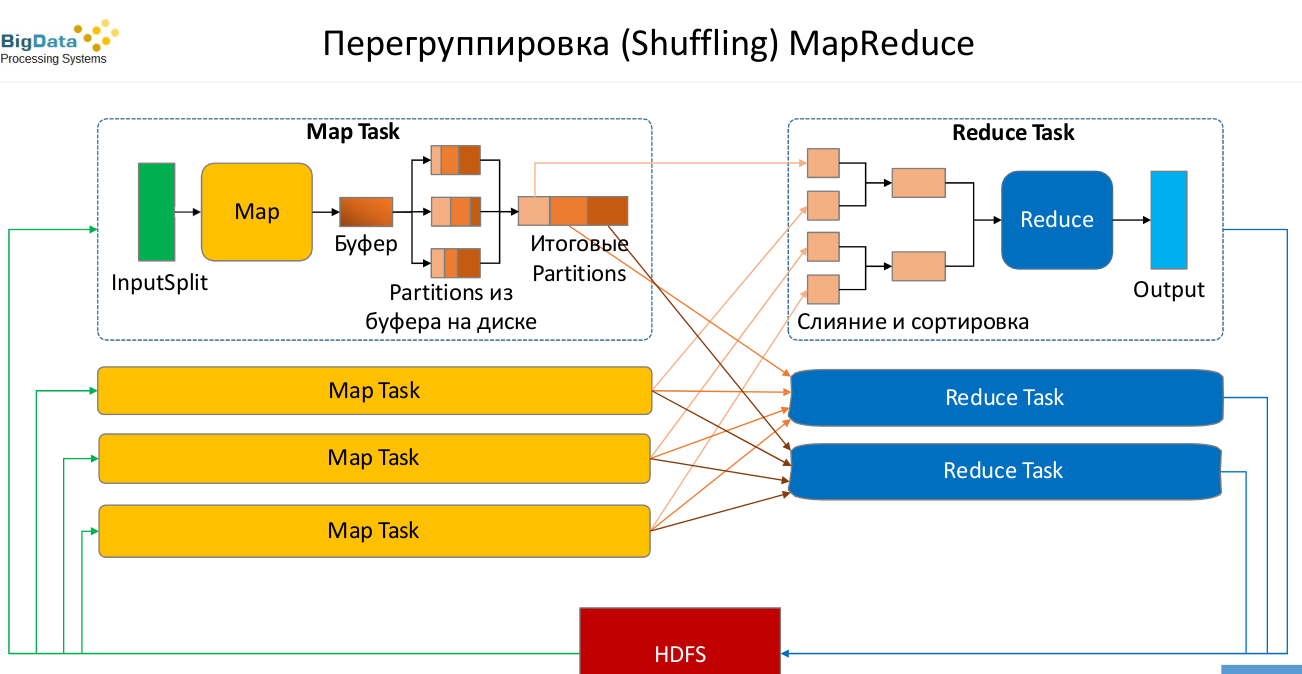

Задачи ReduceTask - дают выходные данные и находятся на серверах
- мы записываем много данных на HDFS, а мы знаем что HDFS не любит такие операции... -> HDFS будет плохо работать на больших класстерах

![image copy 16.png](<attachment:image copy 16.png>)
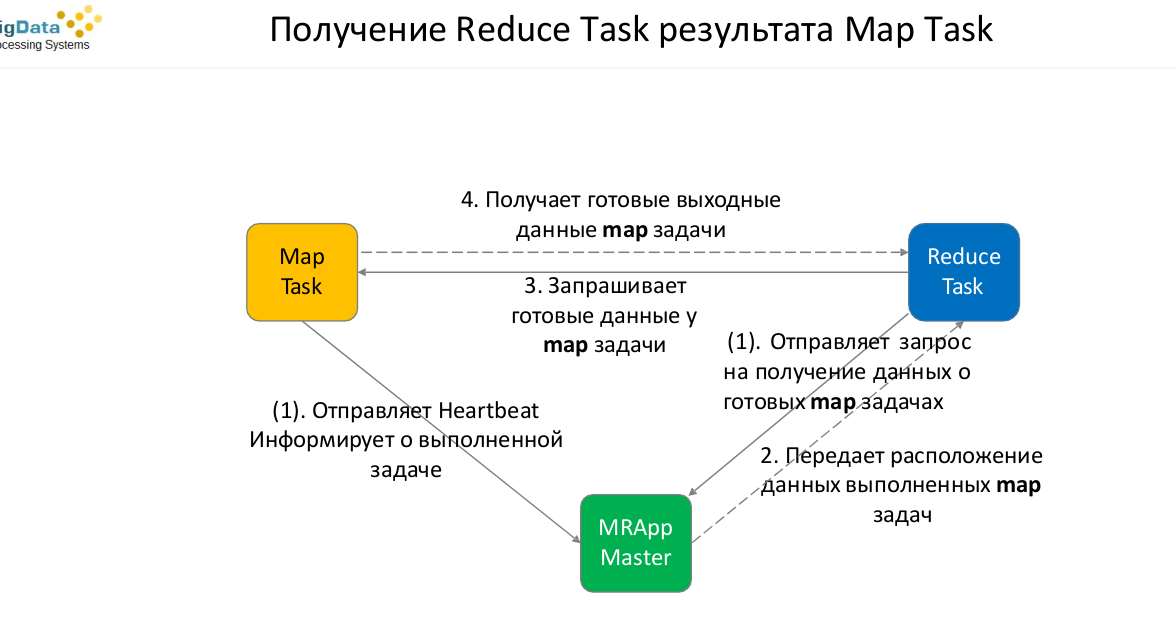

Информация о том, что задача Map закончилась должен, кто-то знать, т.к. только после 5% выполненных Map задач может запускаться Reduce заадча... 

- Получение ReduceTask резульатата MapTask идет через ApplicationMaster

1) (1) Он переодически отправляет Hearbeat - говоря что задача выполнена, и не передает информации о том, как она выполнена с ошибкой или без...
2) Дальше Application Master передает расположение данных у выполненных map-задач. Т.к. Application Master узнает эту информацию через ResourceManager...
1) (1) Reduce Task переодически отправляет запрос на получение данных о выполненных map-задачах
3) Как только Reduce Task получаяет местоположение данных, он начинает запрашивать эти готовые данные
4) Далее он получает эти данные

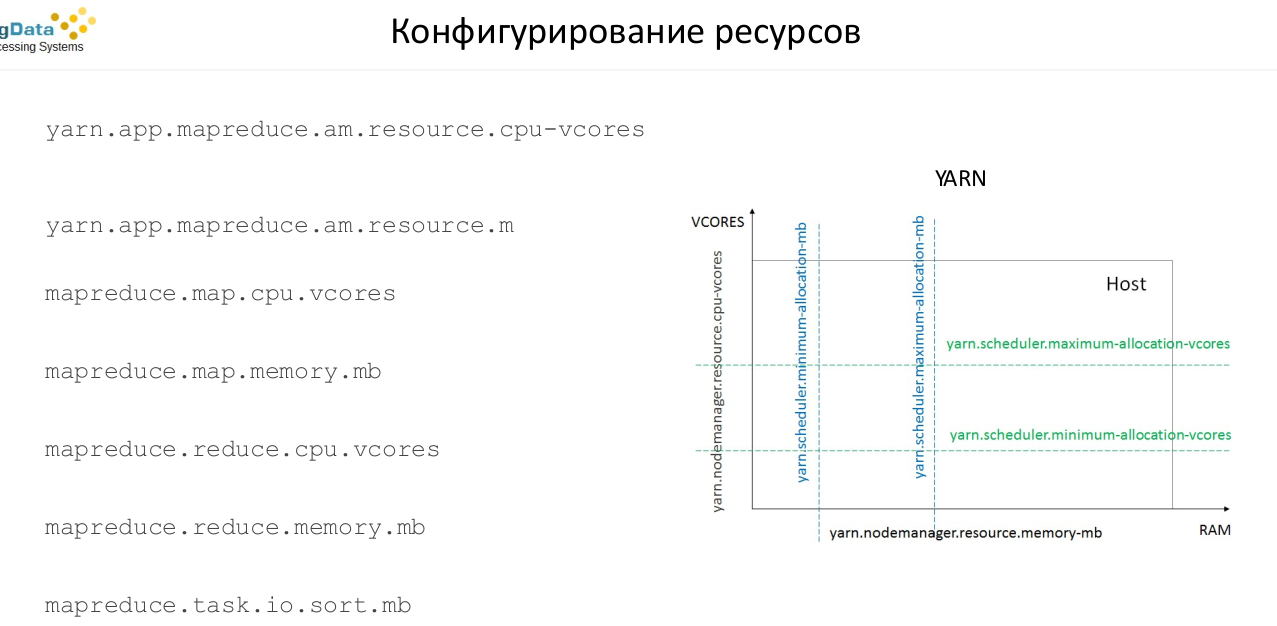

- просто программист должен граммотно задавать пороги...

### Отказаустойчиваость

- у нас есть несколько UseCase-ов, где и как отлавливать ошибки...

![image copy 17.png](<attachment:image copy 17.png>)

4 варианта событий:

1) Отказ задачи(Task Failure):
- ошибка в коде либо исключение
- ошибка в JVM (виртуальной машины)
- зависание задачи - задаче держит ресурса / порог очень сложно достижим (за огромное время...)

2) Отказ Aplication Master-а

3) Отказ NodeManager-a

4) Отказ ResourceManager-а

1 и 2 - отвечает `MapReduce`
1 и 2 и 3 и 4 - `YARN` может фиксировать все задачи 

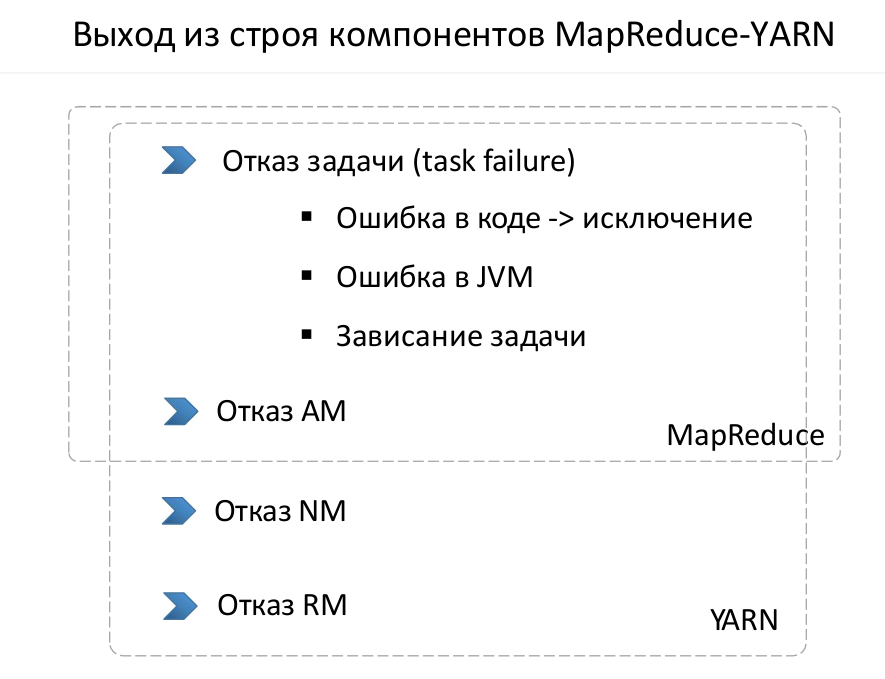

![image copy 18.png](<attachment:image copy 18.png>)
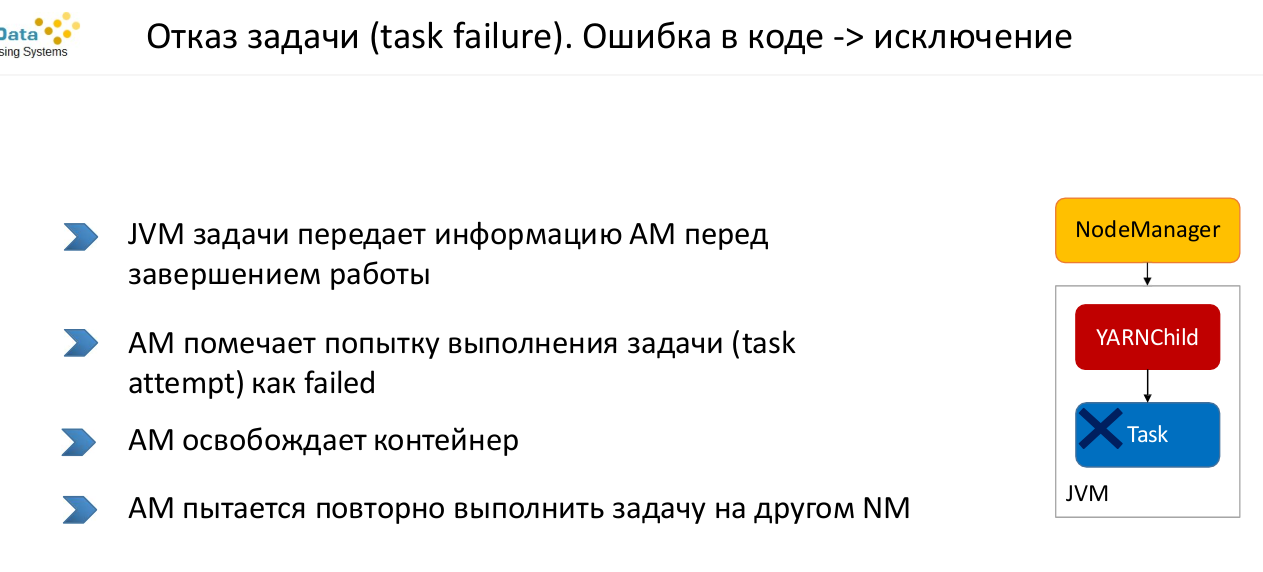

- как и во всех программах для обработки больших данных мы не усложняем работу нашей программы добавляя какие-то сложно аналитические обработчики ошибок, вместо этого мы просто запускаем задачу заново на другом NodeManager-е

![image copy 19.png](<attachment:image copy 19.png>)
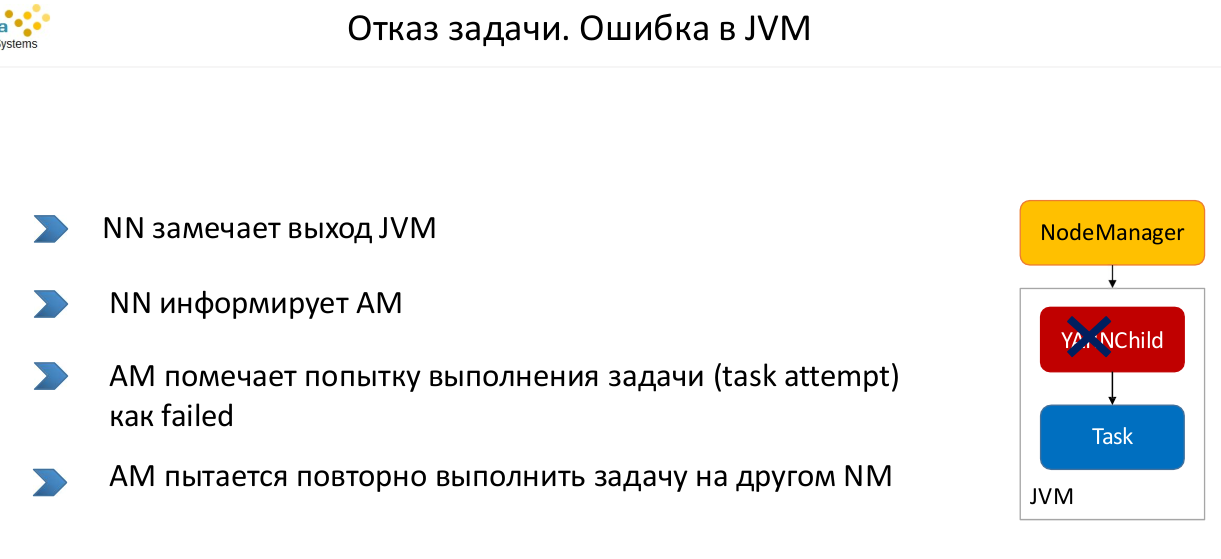

НЕ NN, А NM должен быть

![image copy 20.png](<attachment:image copy 20.png>)
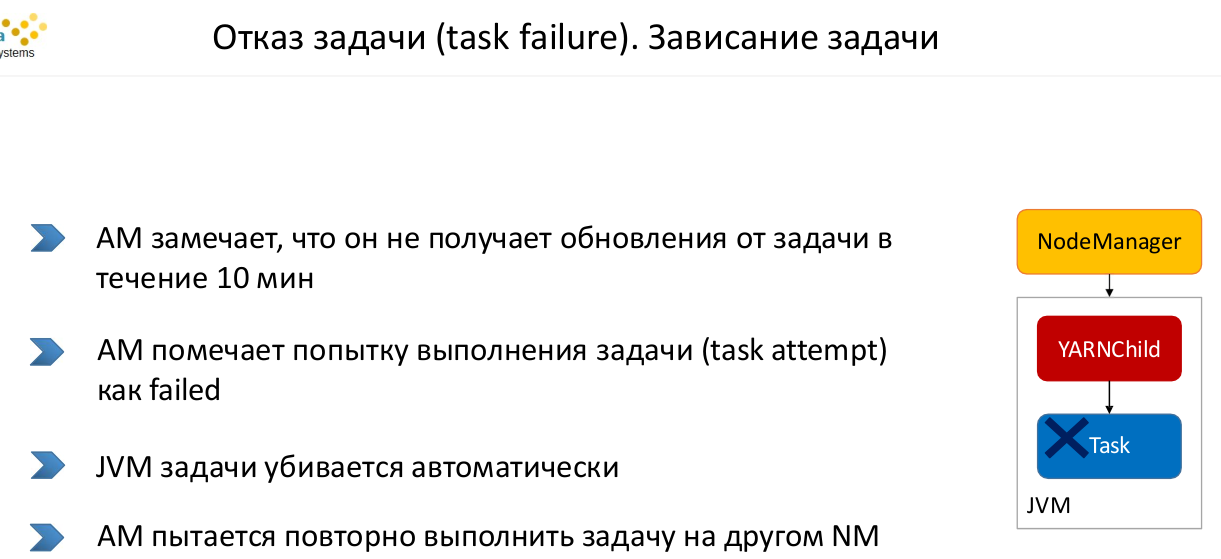

Класстер не замарачивается при возникновении ошибок!

При MapReduce-е не нужно писать код ошибки, Node-а просто упадет и поднимется другая нода.

![image copy 21.png](<attachment:image copy 21.png>)
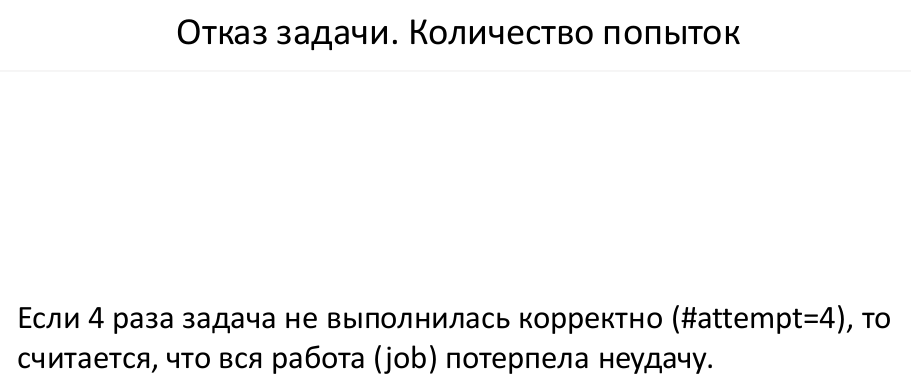

![image copy 22.png](<attachment:image copy 22.png>)
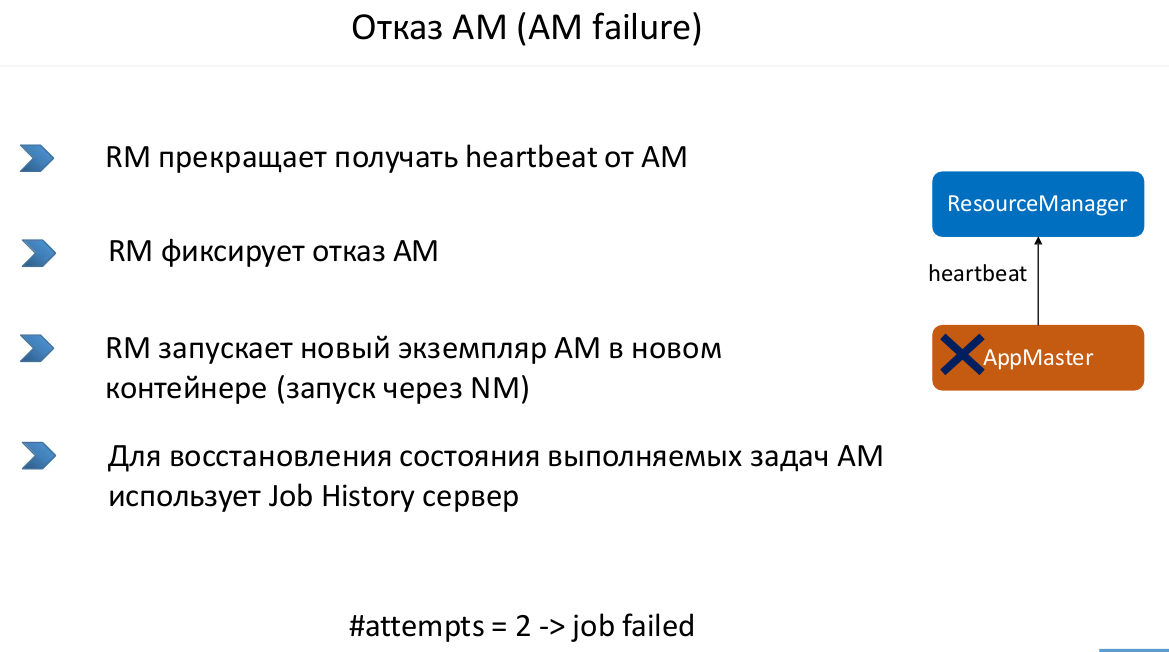

- мы не разбираемся, что произошло, ResourceManager просто поднимет Application Master на другой Node-e

Job History сервер автоматом не поднимается, его нужно поднимать отдельно!

![image copy 23.png](<attachment:image copy 23.png>)
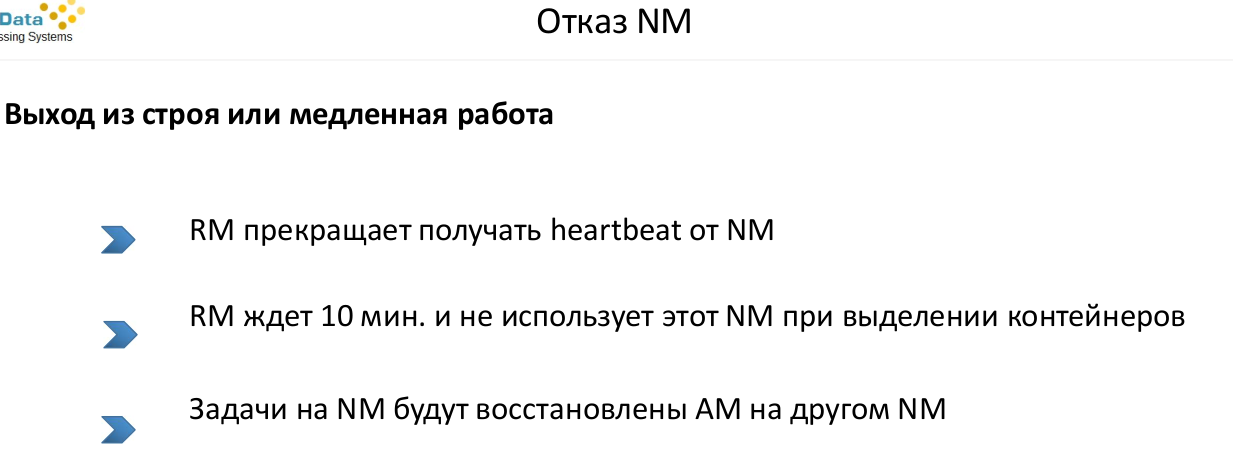

![image copy 24.png](<attachment:image copy 24.png>)
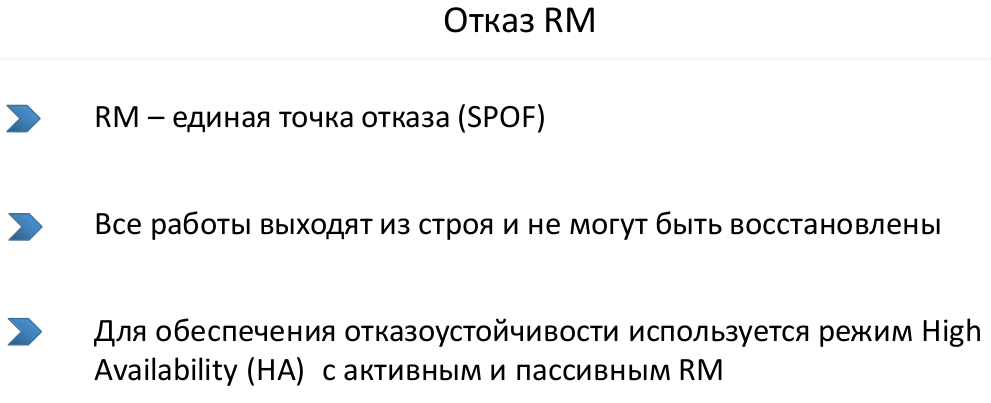

- также как и NameNode

![image copy 25.png](<attachment:image copy 25.png>)
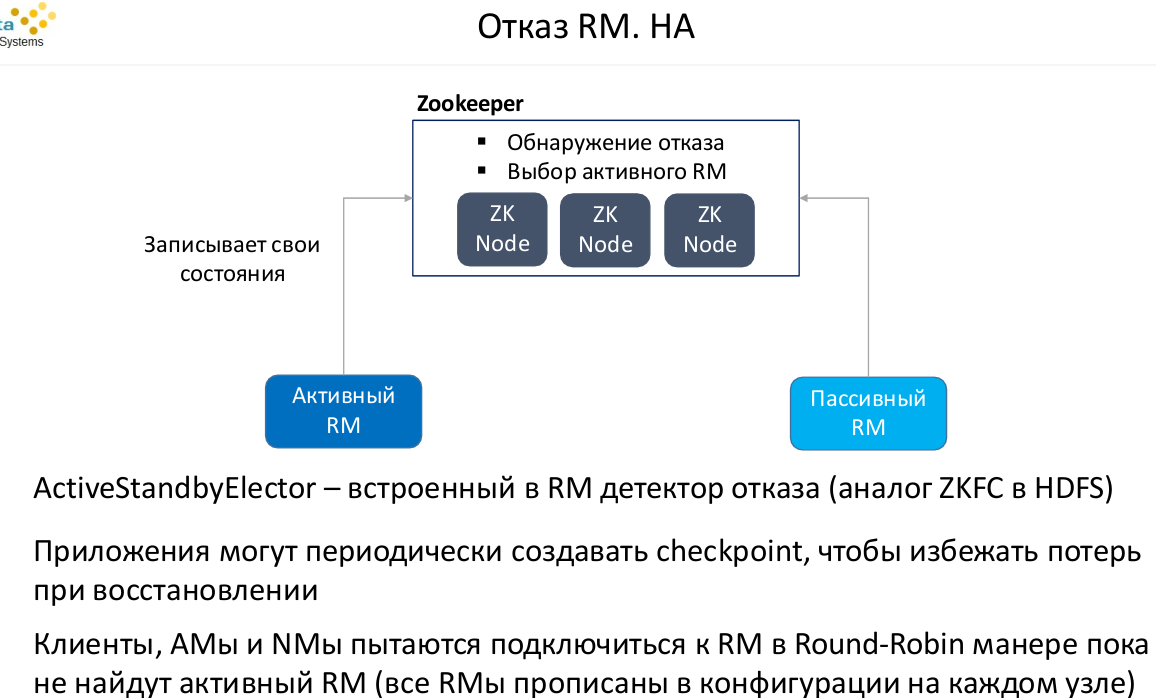

- решение такое же как и у NameNode-а

![image copy 26.png](<attachment:image copy 26.png>)
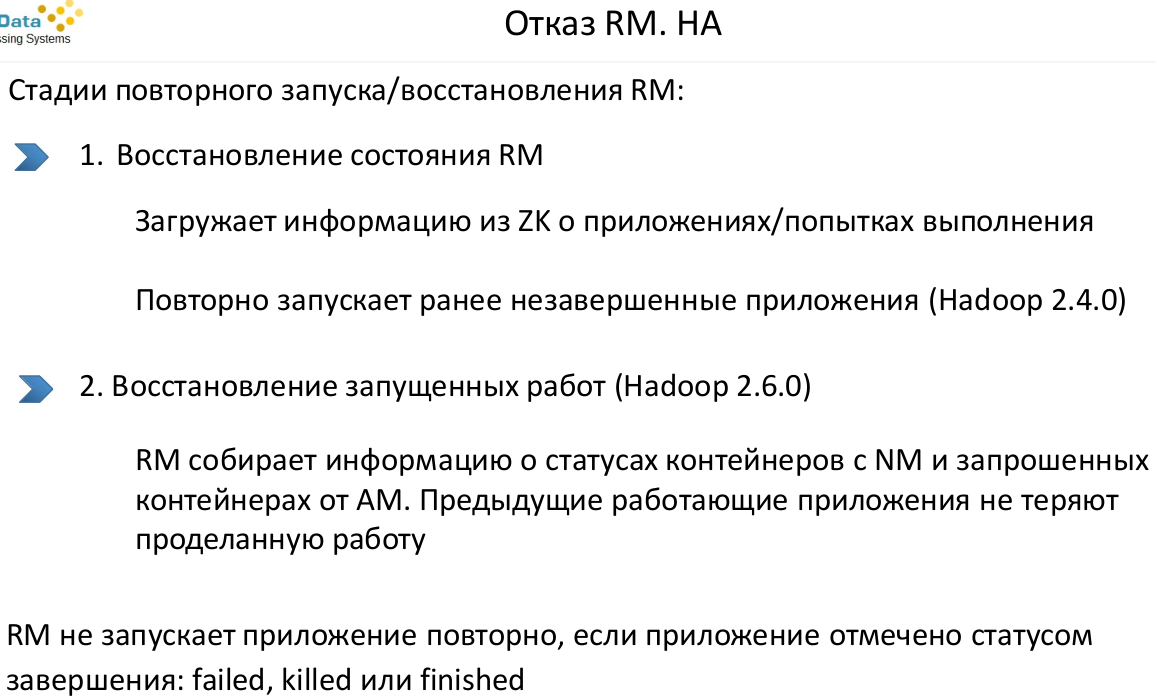

![image copy 27.png](<attachment:image copy 27.png>)
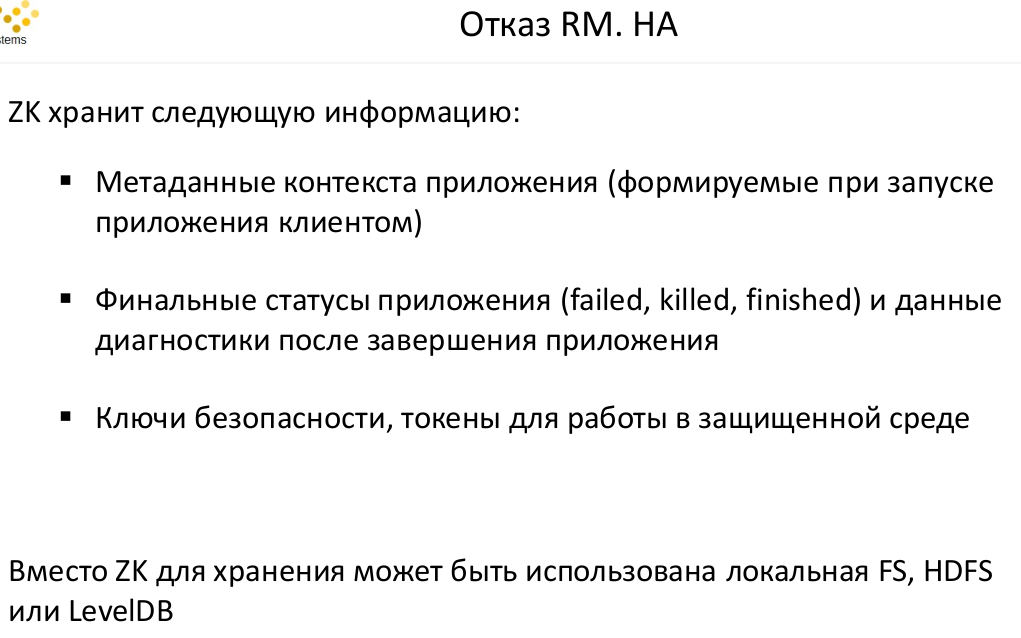

![image copy 28.png](<attachment:image copy 28.png>)
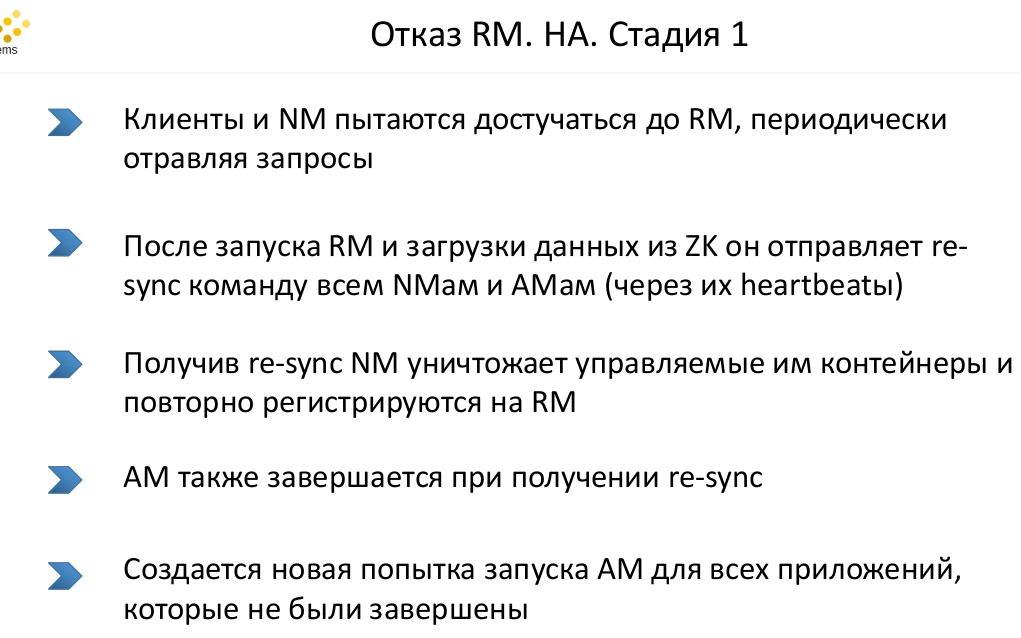

![image copy 29.png](<attachment:image copy 29.png>)
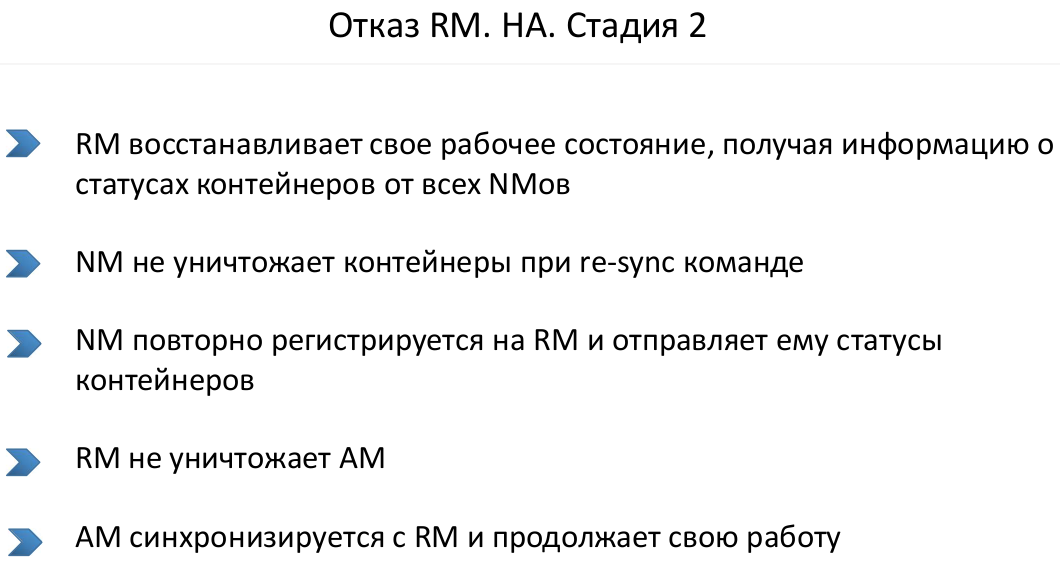

# Практика №3 MapReduce 